# Challenge Description:

## Location description
The well is situated in Bavaria, in the Upper Jurassic Malm Karst aquifer. It is a deep, confined aquifer (partly artisian), which is overlain by a local alluviual aquifer in a small river valley. Surface elevation is about 375 masl, depth to groundwater 0.9 m on average.


## Input data description

The following input data are provided to model the head time series. This data were collected from the E-OBS dataset 
v25.0e at 0.1deg grid size.

- Daily Precipitation (RR) in mm/d.
- Daily mean temperature (TG) in degree Celsius.
- Daily minimum temperature (TM) in degree Celsius.
- Daily maximum temperature (TX) in degree Celsius.
- Daily averaged sea level pressure (PP) in hPa.
- Daily averaged relative humidity (HU) in %.
- Daily mean wind speed (FG) in m/s.
- Daily mean global radiation (QQ) in W/m2.
- Potential evaporation (ET) computed with Makkink in mm/d.

## Calibration and testing data

The head data are split into a training and testing period. Data are provided for the training/calibration period. Participants have to provide a simulated time 
series for the entire period:

- **Training period:** 2002-05-01 to 2016-12-31
- **Testing period:** 2017-01-01 to 2021-12-31

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pickle


from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

import time
import warnings

import tensorflow as tf
from keras.layers import Dense, LSTM
from keras import Sequential


In [7]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
color_pal = sns.color_palette()

<a id='ML'></a>
# Initial ML approach

### Read in data and engineer features:
- More in depth EDA was performed in notebook Germany_EDA

In [20]:
# data paths
feature_path = 'data/Germany/input_data.csv'
target_path = 'data/Germany/heads.csv'

# training time period as specified by the challenge
training_period = '2002-05-01'
challenge_test_period = '2016-12-31'

In [25]:
# read data
def read_data(feature_path, target_path, training_period):
    '''
    Helper function to read in feature and target data
    '''
    df_input = pd.read_csv(feature_path)
    df_input = df_input.set_index('time')
    df_input.index = pd.to_datetime(df_input.index)

    df_y = pd.read_csv(target_path)
    df_y = df_y.set_index('Date')
    df_y.index = pd.to_datetime(df_y.index)
    df_y.index = df_y.index.rename("time")
    df_y = df_y[(df_y.index>=training_period)]

    return df_X, df_y

    


In [44]:
# create lag feature
def lag_features(features, lags, df_input):
    '''
    Helper function to create lag features
    '''
    for j in features:
        temps = pd.DataFrame(df_input[j].values)
        shifted = temps.shift(1)
        for k in lags:
            window, means = {}, {}
            window["{}".format(k)] = shifted.rolling(window=k)
            means["{}".format(k)] = window["{}".format(k)].mean()
            df_input["{}_avg_{}".format(j,k)]=means["{}".format(k)].to_numpy()


    # drop missing values after creating lag features
    df_input.dropna(inplace = True)
    
    return df_input


def create_features(df):
    '''
    Helper function to add time related features
    '''
    #df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    #df['dayofweek'] = df.index.day_of_week
    #df['quarter'] = df.index.quarter
    return(df)

In [52]:
df_input, df_y = read_data(feature_path, target_path, training_period)

In [47]:
# lags were determined by trends of features found in EDA as well as trial and error
# can furthur adjust the number of lags specific to each feature
features = ['rr','tg','tn','tx','pp','hu','fg','qq','et']
lags = [15,30,90]

df_X = lag_features(features, lags, df_input)
df_X = create_features(df_X)

# adjust time frame of df_X and df_y
df_X = df_X[(df_X.index>=training_period)& (df_X.index<=challenge_test_period)]
df_y = df_y[df_y.index >= df_X.index[0]]

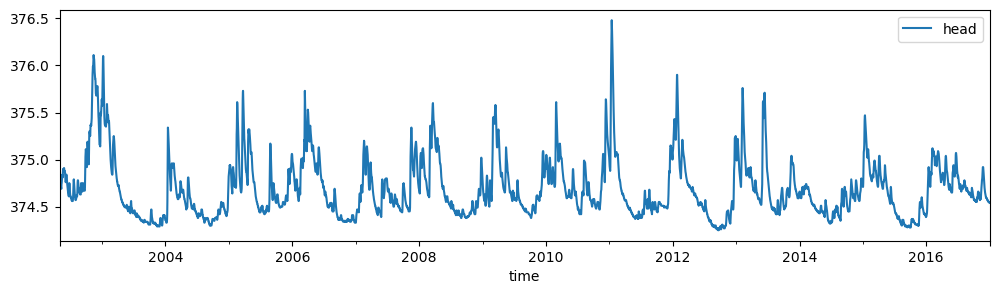

In [28]:
# visualize target data

df_y.plot(figsize=(12,3))
plt.show()

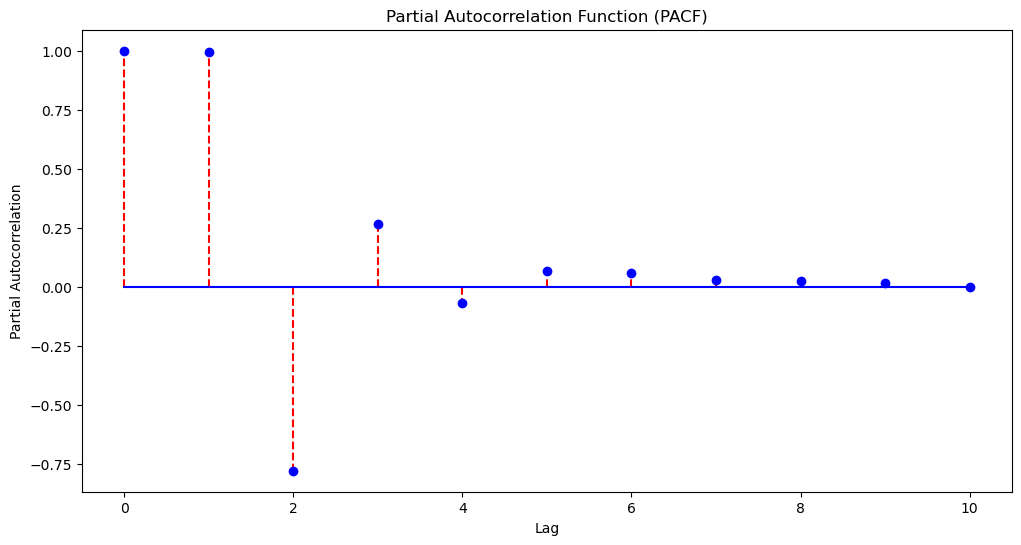

In [14]:
# Partial Autocorrelation Plot of target variable to understand correlation
# Target variable was not allowed to be used for training by the rules of this challenge
# Calculate Partial Autocorrelation Function
pacf_result = sm.tsa.pacf(df_y, nlags=10, method='ols')

# Plot PACF
plt.figure(figsize=(12, 6))
plt.stem(range(len(pacf_result)), pacf_result, markerfmt='bo', basefmt='b-', linefmt='r--')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


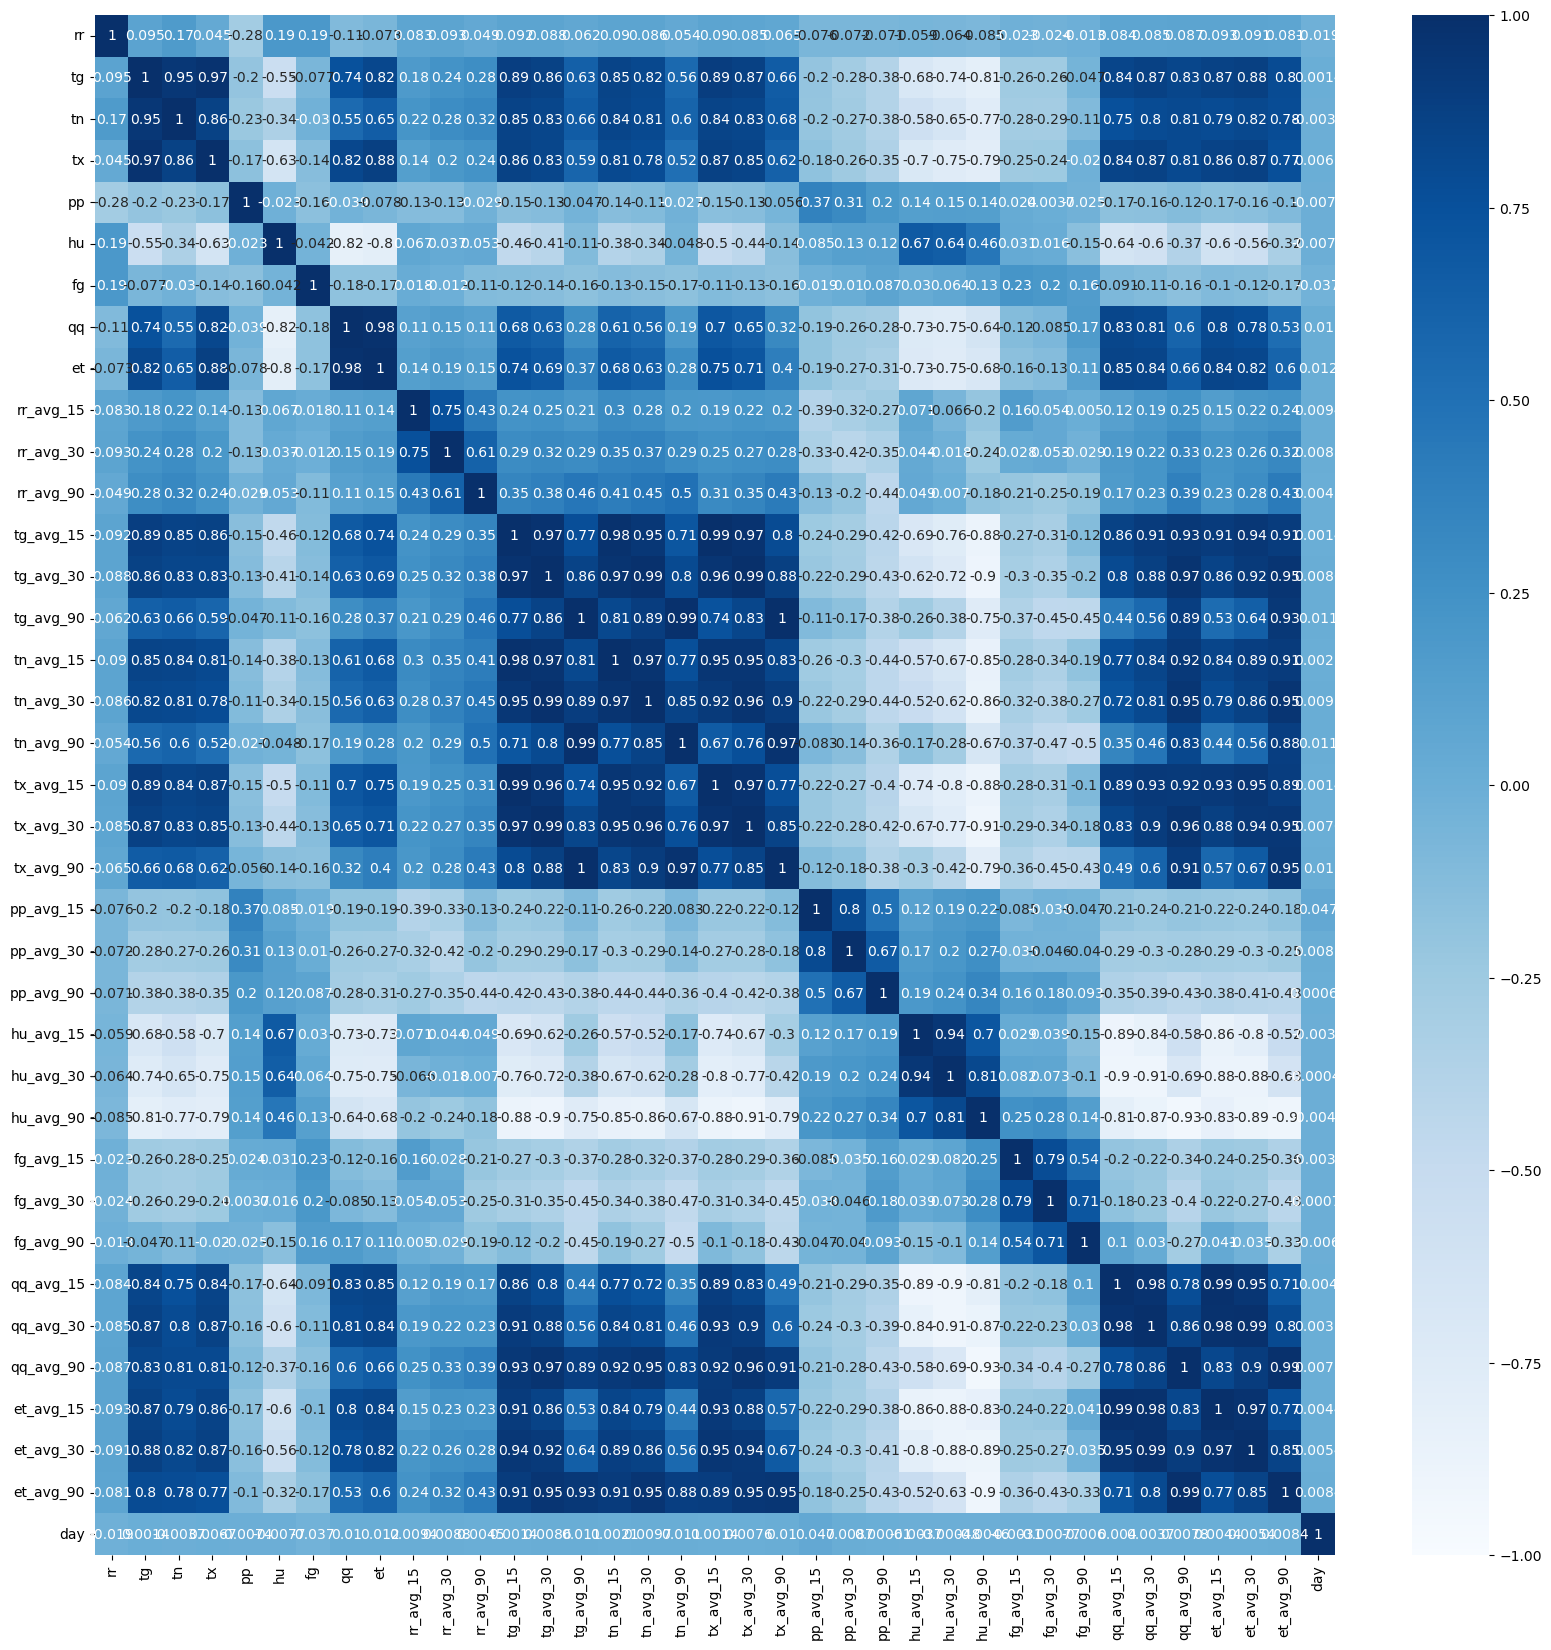

In [64]:
# check for multicolinearity of feature variables
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

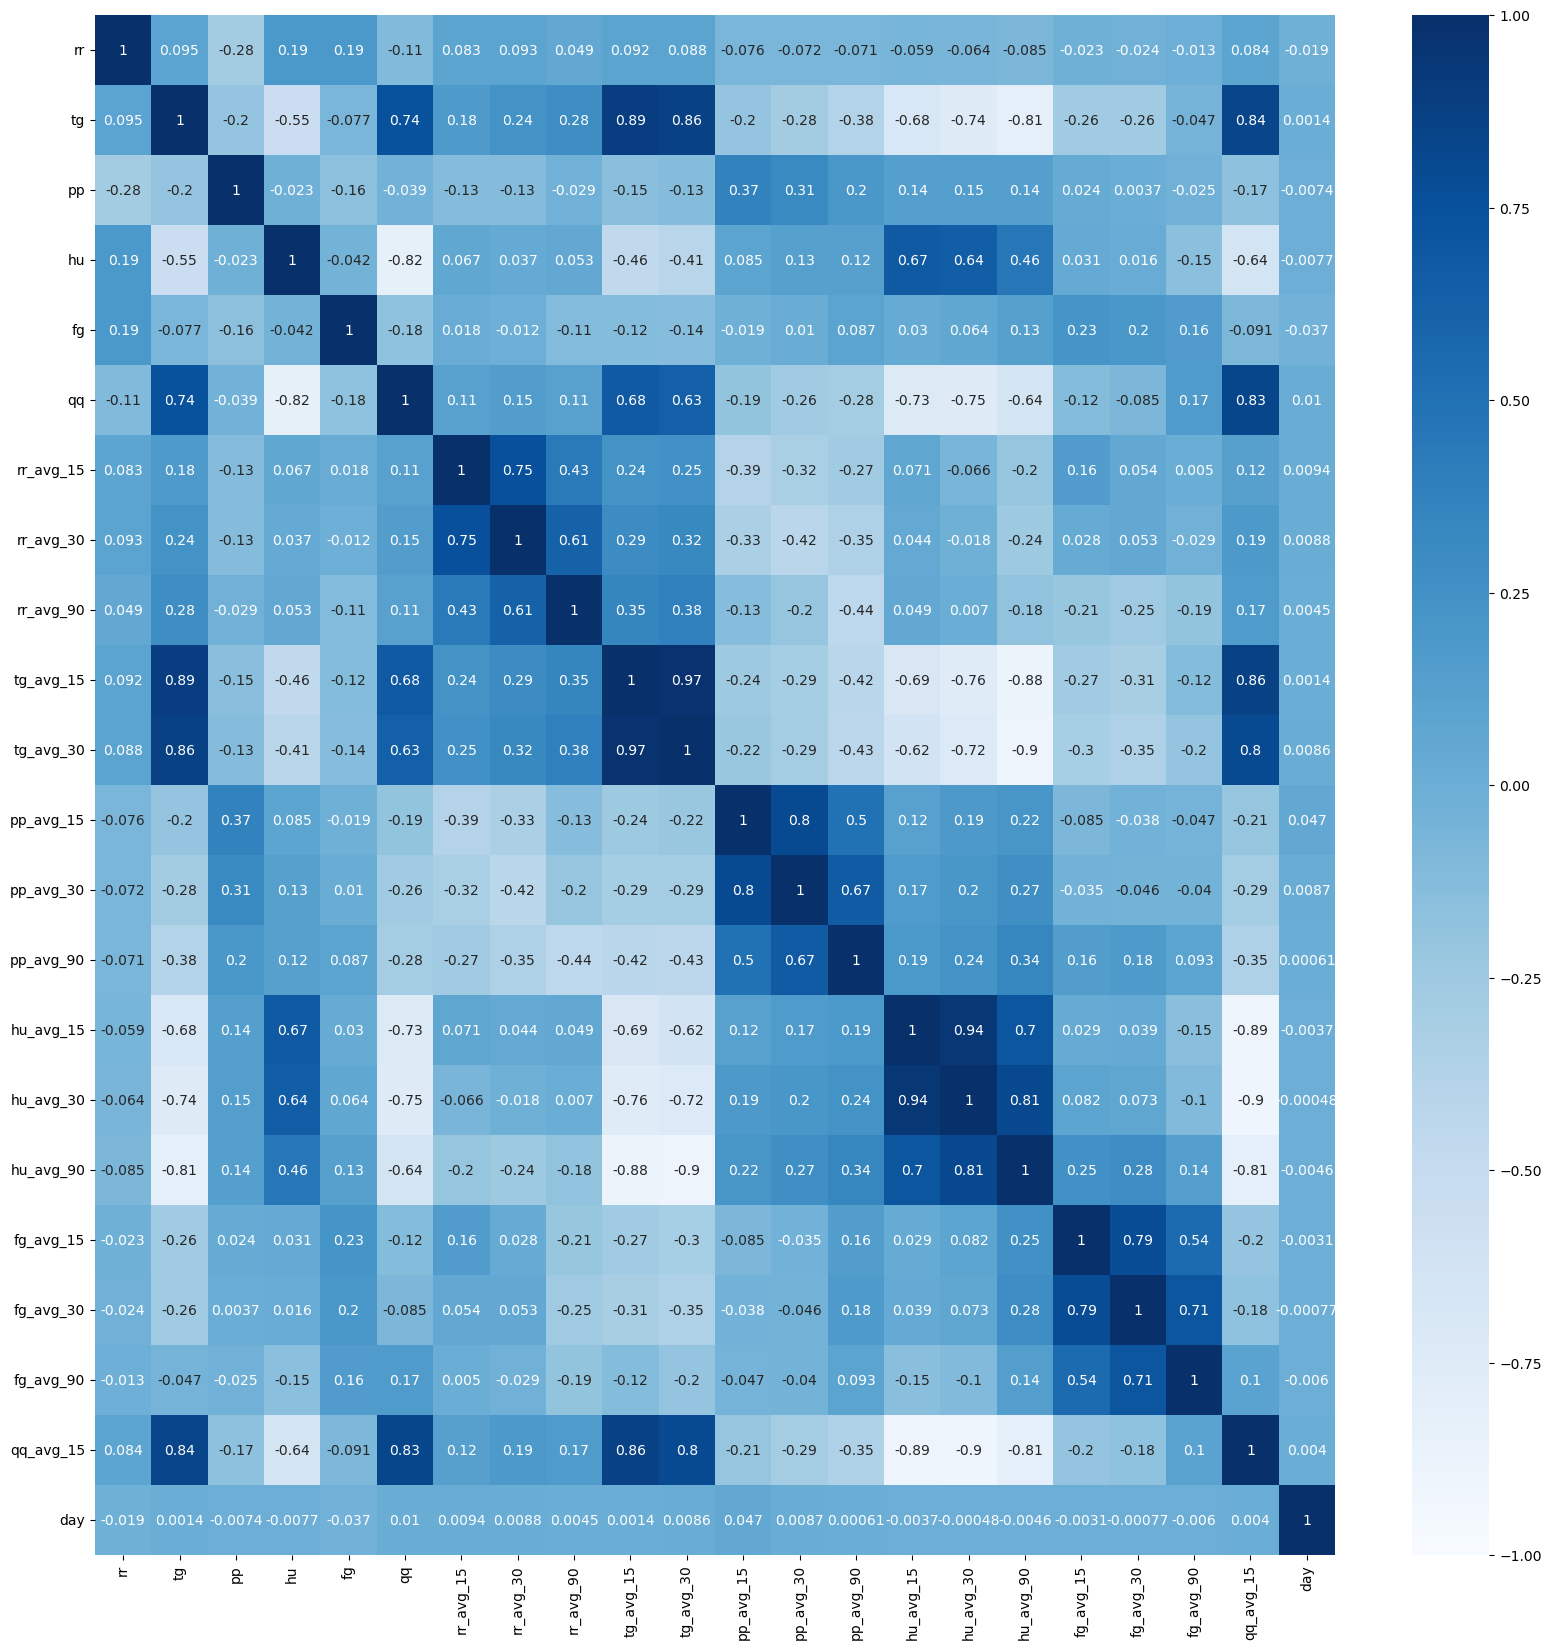

In [65]:
# drop highly correlated features
df_X = df_X.drop(columns=[col for col in df_X.columns if 
                          (col.startswith('tn') or 
                           col.startswith('tx') or 
                           col.startswith('et') or 
                           col in ['qq_avg_30','tg_avg_90','qq_avg_90'])])
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

### Baseline predction model:
We created a baseline model that takes the mean of each day as the predicted value, and calculated the RMSE of this model.

In [29]:
# split data into training and validation set
def baseline_prediction(df_X, df_y, split_year):
    df_y_train = df_y[df_y.index < split_year]
    df_y_val = df_y[df_y.index >= split_year]

    base_y_train = df_y_train
    base_y_val = df_y_val


    base_y_train['year'] = df_y_train.index.year.copy()
    base_y_train['month'] = df_y_train.index.month
    base_y_train['day'] = df_y_train.index.day

    base_prediction = base_y_train.groupby(['month','day'])['head'].mean().reset_index()

    base_y_val = df_y_val
    base_y_val['month'] = df_y_val.index.month
    base_y_val['day'] = df_y_val.index.day

    base_y_val = pd.merge(base_y_val, base_prediction, on=['month','day'], how='left')
    base_y_val.rename(columns={'head_x':'head_true','head_y':'head_pred'}, inplace=True)

    baseline_MSE = mean_squared_error(base_y_val['head_true'],base_y_val['head_pred'])
    
    return baseline_MSE

In [31]:
baseline_mse = baseline_prediction(df_X, df_y, '2014-01-01')
baseline_mse

0.04468291139533852

### Model Training Process Overview:
- We used the MSE as our evaluation metric, and tried three different ML algorithms: Lasso regression, SVR, and random forest regressor
- For training experiment, we define the method of preprocessing and the ML algorithm to use, and then pass our data through the training pipeline to output the best models (models with the best hyperparameter combinations)
- We split the data into train-val and test sets, where observations in the test set always occur later in time than observations in the train-val set. 
- We train the model on the train-val set, predicted on the test set, and calculate an MSE score on the test set.
- During training, we further split the train-val test in to training and validation sets using a time-series split, and use a grid search to perform cross validation to choose the set of hyperparameter combinations that minimizes the MSE score for that model on the validation set.
- We repeated this procedure for 5 iterations, each interation consists of a test set that is later in time than the previous test set, and a train-val set that includes all the datapoints that are earlier in time than the test set. This gives 5 different models and 5 different MSE test scores for each ML algorithm. We do these iterations to account for uncertainties in our model results and test for their generalizability in making predictions for different time periods.
- In the end, we compute the MSE scores on the test sets for each algorithm, and choose the algorithm with the lowest MSE score as our final model

### Build model training pipeline:

In [32]:
def MLpipe_Multisplit_KFold_MSE(ColumnTransformer, 
                                ML_algorithm, 
                                parameter_grid, 
                                det=True,
                                plot_train = False,
                                plot_test = False):
    '''
    Function: performs the entire ML pipeline
    
    Arguments: 
        * columTransformer: transformer specifying how to perform preprocessing
        * ML_algorithm: the ML algorithm used for training
        * parameter_grid: hyperparameters and their range of values to tune during grid search
    
    Output:
        * test_scores: list of MSE scores on the test sets
        * final_models: list of models with the best hyperparameter combinations in each iteration
    '''
    
    preprocessor = ColumnTransformer

    prep = Pipeline(steps=[('preprocessor', preprocessor)]) 
    param_grid = parameter_grid 
    
    nr_states = 5 # number of random states
    test_scores = np.zeros(nr_states)
    final_models = []

    # define the first year used for splitting out test set
    base_train_year = 2012
    
    for i in range(nr_states):
        
        # split data into other and test set
        # the split year shifts forward for each iteration, so we have different test sets for each iteration
        split_year = base_train_year + i
        split_date = '{}-01-01'.format(split_year)
        test_end_date = '{}-01-01'.format(split_year+1)
        print('split_year: ', split_year)

        feature_matrix_other=df_X[df_X.index<split_date]
        feature_matrix_test=df_X[(df_X.index>=split_date) & (df_X.index < test_end_date)]
        target_variable_other_df=df_y[df_y.index<split_date]
        target_variable_test_df=df_y[(df_y.index>=split_date) & (df_y.index < test_end_date)]

        target_variable_other=target_variable_other_df.values.ravel()
        target_variable_test=target_variable_test_df.values.ravel()

        #split train and validation using time series splitting, used during cross validation
        tsp = TimeSeriesSplit(n_splits=4)

        # initialize the algorithm
        if det:
            # for deterministic algorithms
            reg = ML_algorithm
        else:
            # for non-deterministic algorithms
            reg = ML_algorithm.set_params(random_state = 42*i) 
        
        # initialize pipeline, steps include: preprocessing and training the ML algorithm
        pipe = make_pipeline(preprocessor,
                             reg)

        # initialize GridSearchCV for hyperparameter tuning
        grid = GridSearchCV(pipe, 
                            param_grid=param_grid,
                            scoring = 'neg_mean_squared_error',
                            cv=tsp, 
                            return_train_score = True, 
                            n_jobs=-1, 
                            verbose=True)
        
        # fit the model on training and validation sets
        grid.fit(feature_matrix_other, target_variable_other)
        
        # save results into a data frame
        results = pd.DataFrame(grid.cv_results_)
        print('best model parameters:',grid.best_params_)
        final_models.append(grid)
        
        # calculate and save the test scores
        target_variable_test_pred = final_models[-1].predict(feature_matrix_test)
        test_scores[i] = mean_squared_error(target_variable_test,target_variable_test_pred)
        std_test = np.std(target_variable_test_pred)
        print('test score:',test_scores[i])
        
        
        # visualize model predictions on training and testing set
        
        # train set plot
        if plot_train:
            target_variable_other_pred = final_models[-1].predict(feature_matrix_other)
            prediction = pd.DataFrame(target_variable_other_pred,index=target_variable_other_df.index)
            ax = target_variable_other_df.plot(figsize=(10,6))
            prediction.plot(ax=ax)
            plt.legend(["training data","prediction"])
            plt.title("Prediction on Training Set")
            plt.xlabel('time')
            plt.ylabel('head')
            plt.show()
        
        # test set plot
        if plot_test:
            prediction = pd.DataFrame(target_variable_test_pred,index=target_variable_test_df.index)
            ax = target_variable_test_df.plot(figsize=(10,6))
            prediction.plot(ax=ax)
            plt.legend(["testing data","prediction"])
            plt.title("Prediction on Testing Set")
            plt.xlabel('time')
            plt.ylabel('head')
            plt.show()
    
    # print out mean of test scores
    print('mean of test scores:',np.mean(test_scores))
    
    return test_scores, final_models

### Train models:

In [ ]:
# define data preprocessing methods:
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]

columnTransformer=ColumnTransformer(transformers=[('onehot', 
                                                   OneHotEncoder(sparse_output=False,handle_unknown='ignore'), 
                                                   onehot_ftrs),
                                                  ('std', 
                                                   StandardScaler(), 
                                                   std_ftrs)],
                                    remainder='passthrough')

In [48]:
# lasso regression

ML_algorithm=Lasso()
parameter_grid = {'lasso__alpha': np.logspace(-2,2,11)} 

lasso_test_scores, lasso_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)

split_year:  2012
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.04191827155748873
split_year:  2013
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.029934096435244792
split_year:  2014
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.008853140358237217
split_year:  2015
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.020783363474059402
split_year:  2016
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.03541951398584992
mean of test scores: 0.02738167716217601


In [49]:
# random forest

ML_algorithm=RandomForestRegressor()
parameter_grid = {'randomforestregressor__max_depth': [1,5,10,30,50,100],'randomforestregressor__max_features': [0.01,0.25,0.5,0.75,1]} 

start_time = time.time()
rf_test_scores, rf_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid, det=False)
end_time = time.time()
rf_runtime = end_time-start_time
print(rf_runtime)

split_year:  2012
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.25}
test score: 0.04483481588855575
split_year:  2013
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.25}
test score: 0.06258541661584366
split_year:  2014
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 0.25}
test score: 0.01386573465067748
split_year:  2015
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.5}
test score: 0.01493910865890543
split_year:  2016
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforest

In [50]:
# SVR
ML_algorithm=SVR()
parameter_grid = {'svr__gamma': [1e-2, 1e-1, 1e1, 1e2, 1e3],'svr__C': [1e-1, 1e0, 1e1]} 

start_time = time.time()
SVR_test_scores, SVR_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)
end_time = time.time()
SVR_runtime = end_time-start_time
print(SVR_runtime)

split_year:  2012
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 1.0, 'svr__gamma': 0.01}
test score: 0.04219660338349075
split_year:  2013
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.033593689441354775
split_year:  2014
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.004458758534293374
split_year:  2015
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.01833455293246648
split_year:  2016
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 0.1, 'svr__gamma': 0.01}
test score: 0.03528602182649463
mean of test scores: 0.026773925223620005
30.802592039108276


## Model Results

We chose SVR as our final model because it is the model with the lowest mean RMSE.

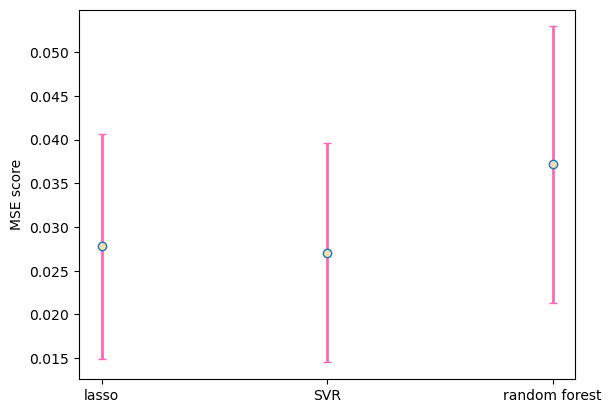

In [85]:
lasso_mean = np.mean(lasso_test_scores)
lasso_std = np.std(lasso_test_scores)

SVR_mean = np.mean(SVR_test_scores)
SVR_std = np.std(SVR_test_scores)

rf_mean = np.mean(rf_test_scores)
rf_std = np.std(rf_test_scores)

plt.errorbar(['lasso','SVR','random forest'],[lasso_mean,SVR_mean,rf_mean], yerr=[lasso_std,SVR_std,rf_std],ecolor="hotpink",fmt="o",elinewidth=2,mfc="wheat",capsize=3)
plt.ylabel('MSE score')
plt.show()

In [87]:
# save the 5 SVR models
import pickle
for i in range(5):
    model = SVR_models[i]
    filename = 'germany_models/SVR_model_{}.sav'.format(i)
    pickle.dump(model, open(filename, 'wb'))


## Predict on challenge test data for submission

In [53]:
# prepare and preprocess data for the submission test set
submission_X = df_input[df_input.index>='2002-05-01']
submission_X = create_features(submission_X)
submission_X = submission_X.drop(columns=[col for col in submission_X.columns if (col.startswith('tn') or col.startswith('tx') or col.startswith('et') or col in ['qq_avg_30','tg_avg_90','qq_avg_90'])])

submission_X

,rr,tg,pp,hu,fg,qq,rr_avg_15,rr_avg_30,rr_avg_90,tg_avg_15,...,pp_avg_30,pp_avg_90,hu_avg_15,hu_avg_30,hu_avg_90,fg_avg_15,fg_avg_30,fg_avg_90,qq_avg_15,day
time,,,,,,,,,,,,,,,,,,,,,
2003-07-25,0.000000,19.060000,1014.10004,73.725000,1.49,267.0,2.800000,2.546667,2.225556,20.657333,...,1014.613343,1015.702231,63.196175,67.683589,69.943304,1.990000,1.971667,2.224667,280.733333,25
2003-07-26,0.000000,21.189999,1012.20000,70.215004,1.63,181.0,2.800000,2.546667,2.213333,20.660666,...,1014.480009,1015.741120,63.953509,67.998755,70.094749,1.960000,1.962333,2.213778,278.000000,26
2003-07-27,9.400001,22.650000,1011.60004,70.445000,2.53,215.0,2.800000,2.546667,2.213333,20.715333,...,1014.390009,1015.728898,64.786842,68.562089,70.096249,1.968000,1.971333,2.186889,268.600000,27
2003-07-28,0.000000,18.320000,1019.60004,71.160000,2.75,206.0,3.426667,2.783333,2.317778,20.892666,...,1014.320011,1015.745564,65.302509,68.606755,70.259971,1.998667,2.003000,2.193778,266.066667,28
2003-07-29,0.000000,17.880000,1022.10004,60.435000,1.67,228.0,3.426667,2.783333,2.317778,20.898666,...,1014.536677,1015.822231,66.227842,68.458255,70.300527,2.050000,2.048333,2.194889,259.533333,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,0.000000,2.470000,1039.90000,84.810000,4.71,27.0,0.193333,0.210000,0.987778,1.387333,...,1030.503363,1023.053348,92.002236,91.070217,90.570080,2.611333,2.448667,2.408778,24.533333,27
2016-12-28,0.000000,3.510000,1043.10000,85.750000,3.62,28.0,0.193333,0.210000,0.987778,1.308000,...,1031.206697,1023.184459,91.428617,90.790550,90.544524,2.711333,2.529000,2.435222,24.666667,28
2016-12-29,0.000000,-1.310000,1042.10000,95.075005,2.09,51.0,0.086667,0.210000,0.987778,1.475333,...,1031.700030,1023.421126,90.977152,90.705383,90.600969,2.846667,2.557000,2.443556,24.466667,29


In [54]:
# using final models to create 5 predictions on the submission test set
def final_predictions(submission):
    predictions = []
    for i in range(5):
        model = pickle.load(open('germany_models/SVR_model_{}.sav'.format(i), 'rb'))
        prediction = model.predict(submission)
        predictions.append(prediction)
    predictions = np.array(predictions)

    # calculate the mean and 95% prediction interval
    # 96% confidence with 4 degress of freedom gives a t score of 2.774
    pred_std = np.std(predictions,axis=0)
    pred_mean = np.mean(predictions,axis=0)
    upper = pred_mean + 2.774*pred_std
    lower = pred_mean - 2.774*pred_std

    return pred_mean, upper, lower

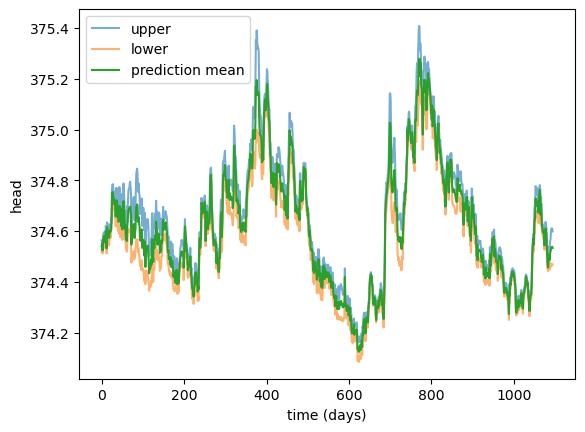

In [59]:
# plot predicted intervals
pred_mean, upper, lower = final_predictions(submission_X)
plt.plot(upper[-1095:],alpha=0.6,label='upper')
plt.plot(lower[-1095:],alpha=0.6,label='lower')
plt.plot(pred_mean[-1095:],label='prediction mean')
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('head')
plt.show()

## LSTM approach: [model tuning work in progress]


In [235]:
feature_path = 'data/Germany/input_data.csv'
target_path = 'data/Germany/heads.csv'

In [257]:
def read_data(target_path, feature_path):
    
    '''
    Function: reads in target and feature data into dataframes
    
    Arguments:
        * target_path: path to target data
        * feature path: path to feature data
    
    Return: 
        * df: dataframe combining feature and target data
    
    '''
    
    # read feature data
    df_X = pd.read_csv(feature_path)
    df_X = df_X.set_index('time')
    df_X.index = pd.to_datetime(df_X.index)

    # filter feature data for data within training period
    df_X = df_X[(df_X.index>='2002-05-01' )& (df_X.index<='2016-12-31')]

    # read target data
    df_y = pd.read_csv(target_path)
    df_y = df_y.set_index('Date')
    df_y.index = pd.to_datetime(df_y.index)
    df_y.index = df_y.index.rename('time')
    df_y = df_y[(df_y.index>=df_X.index[0])]

    df = pd.concat([df_X, df_y], axis=1)
    
    return df

In [253]:
df = read_data(target_path, feature_path)

### Feature Engineering:

In [258]:
class engineer_features():
    '''
    Class to perform various types of feature engineering, new functions to be added
    '''
    def __init__(self, df):
        self.df = df
    
    def year_signal(self):
        timestamp_s = self.df.index.map(pd.Timestamp.timestamp)
        day = 24*60*60
        year = (365.2425)*day

        self.df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
        self.df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
        
        # visualize year signal:
        plt.plot(np.array(df['Year sin'])[:300])
        plt.plot(np.array(df['Year cos'])[:300])
        plt.xlabel('Time [h]')
        plt.title('Year signal')
        plt.show()
        
    def lag_features(self, features):
        # create lag feature
        for j in features:
            temps = pd.DataFrame(self.df[j].values)
            shifted = temps.shift(1)
            for k in lags:
                window, means = {}, {}
                window["{}".format(k)] = shifted.rolling(window=k)
                means["{}".format(k)] = window["{}".format(k)].mean()
                self.df["{}_avg_{}".format(j,k)]=means["{}".format(k)].to_numpy()


        # drop missing values after creating lag features
        self.df.dropna(inplace = True)
    

In [259]:
def split(df, val_year, test_year):
    '''
    helper function to split dataset into train-val-test sets
    '''
    
    train_df = df[df.index < val_year]
    val_df = df[(df.index >= val_year) & (df.index < test_year)]
    test_df = df[(df.index >= test_year)]
    
    return train_df, val_df, test_df


In [292]:
class Standardize():
    def __init__(self, train_df, val_df, test_df, target_col):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.train_mean = self.train_df.mean()
        self.train_std = self.train_df.std()
        self.target_col = target_col
    
    def scale(self):
        self.train_df = (self.train_df - self.train_mean) / self.train_std
        self.val_df = (self.val_df - self.train_mean) / self.train_std
        self.test_df = (self.test_df - self.train_mean) / self.train_std
        
        return self.train_df, self.val_df, self.test_df
        
        
    def reverse_scale_target(self, data):
        reversed_data = data * self.train_std[self.target_col] + self.train_mean[self.target_col]
        
        return reversed_data
        
    

In [261]:
def split_X_y(train_df, val_df, test_df):
    
    train_X_df = train_df.drop(columns = ['head'])
    train_y_df = train_df['head']

    val_X_df = val_df.drop(columns = ['head'])
    val_y_df = val_df['head']

    test_X_df = test_df.drop(columns = ['head'])
    test_y_df = test_df['head']
    
    return train_X_df, train_y_df, val_X_df, val_y_df, test_X_df, test_y_df


In [262]:
# reshape data for training and testing:
def reshape_data(window_length, X, y, return_label_sequence = False):
    '''
    helper function to reshape data for lstm model
    
    Arguments:
        * window_length: int
            + number of time steps in each input sequence for lstm
        * X: pd.DataFrame
            + feature dataframe
        * y: pd.DataFrame
            + target dataframe
        * return_label_sequence: bool
            + if True, will perform rolling window on y for an LSTM model that predicts a sequence
            + if False, will return y as a 1d tensor for an LSTM model that only predicts the final output
    
    Return:
        * reshaped X
        * reshaped y
    
    '''

    # Define a list to hold the resulting tensors
    X_tensors = []
    y_tensors = []
    
    # Reshape X
    for window in X.rolling(window=window_length):
        # Extract the data from the window
        window_data = window.values

        # Check if the window has enough data points
        if len(window_data) == window_length:
            X_tensors.append(window_data)
            
    X_final_tensor = np.stack(X_tensors)
    X_final_tensor = X_final_tensor.reshape(-1, window_length, X.shape[1])
    
    # Reshape y
    
    # if we want to return a sequence in LSTM, perform windowing on y
    if return_label_sequence:
        for window in y.rolling(window=window_length):
            # Extract the data from the window
            window_data = window.values

            # Check if the window has enough data points
            if len(window_data) == window_length:
                y_tensors.append(window_data)
        y_final_tensor = np.stack(y_tensors)
    # if we don't want to return a sequence in LSTM, return y as a 1d array
    else:
        y_final_tensor = y[window_length-1:]

    return tf.constant(X_final_tensor), tf.constant(y_final_tensor)



In [288]:
# perform the entire splitting and preprocessing pipeline:
def preprocessing_pipeline(df, 
                           val_year,
                           test_year, 
                           window_length, 
                           scaling,
                           target_col,
                           return_sequence = None
                          ):
    '''
    Function: performs splitting, scaling, reshaping and other preprocessing steps on data
    
    Arguments:
        * df: pd.DataFrame
            + dataframe containing target and feature data
        * val_year: string
            + split year between training and validation periods
        * test_year: string
            + split year between validation and testing periods
        * window_length: int
            + number of time steps in each input sequence for lstm
        * scaling: object
            + method of scaling data
        * target_col: string
            + name of target variable
        * return_label_sequence: bool
            + if True, will perform rolling window on y for an LSTM model that predicts a sequence
            + if False, will return y as a 1d tensor for an LSTM model that only predicts the final output
    Returns:
        train_X, train_y, val_X, val_y, test_X, test_y
    '''
    
    # perform splitting and standardizing
    train_df, val_df, test_df = split(df, val_year, test_year)
    
    scale_method = scaling(train_df, val_df, test_df, target_col)
    train_df, val_df, test_df = scale_method.scale()
    
    (train_X, train_y, val_X, val_y, test_X, test_y) = split_X_y(train_df, val_df, test_df)
    
    # reshape data
    train_X, train_y = reshape_data(window_length, train_X, train_y, return_sequence)
    val_X, val_y = reshape_data(window_length, val_X, val_y, return_sequence)
    test_X, test_y = reshape_data(window_length, test_X, test_y, return_sequence)
    
    
    return train_X, train_y, val_X, val_y, test_X, test_y, scale_method
    

In [297]:
scale_method.reverse_scale_target(y_test)

<tf.Tensor: shape=(337,), dtype=float64, numpy=
array([496.28166241, 496.27517534, 496.2978801 , 496.3238284 ,
       496.33355902, 496.34004609, 496.35950732, 496.3659944 ,
       496.35950732, 496.34653317, 496.34004609, 496.34004609,
       496.34977671, 496.35626378, 496.35626378, 496.34977671,
       496.34653317, 496.34004609, 496.34004609, 496.33031548,
       496.31734133, 496.30761071, 496.31409779, 496.33031548,
       496.33031548, 496.33680256, 496.33680256, 496.33355902,
       496.3238284 , 496.31409779, 496.30761071, 496.30436718,
       496.30761071, 496.3238284 , 496.33680256, 496.34004609,
       496.34004609, 496.34653317, 496.34977671, 496.35626378,
       496.35302025, 496.35302025, 496.34977671, 496.34653317,
       496.34004609, 496.33355902, 496.3238284 , 496.31409779,
       496.30761071, 496.2978801 , 496.28814949, 496.28166241,
       496.27517534, 496.26868826, 496.25895765, 496.25247057,
       496.24922703, 496.25571411, 496.25571411, 496.25895765,
       

In [314]:
# Build LSTM model:
def get_model(lstm_size, output_size = 1):     

    # design network
    model = Sequential()
    model.add(LSTM(lstm_size))
    model.add(Dense(output_size))

    
    # train model
    model.compile(loss='mse', 
                  optimizer='adam')
    
    return model

# plot history
def plot_training_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    




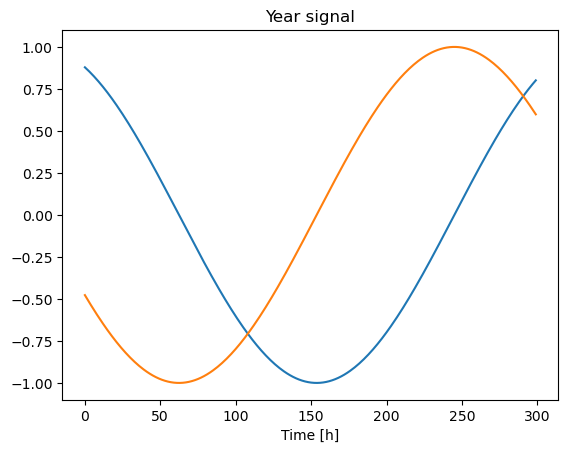

In [310]:
# perform feature engineering

lstm_ft_eng = engineer_features(df)
lstm_ft_eng.year_signal()

df = lstm_ft_eng.df

# create train-val-test data
train_X, train_y, val_X, val_y, test_X, test_y, scale_method = preprocessing_pipeline(df, '2015','2016', 30, Standardize, 'head')

In [316]:
# fit model:
lstm_model = get_model(50,1)

history = model.fit(train_X, 
                    train_y, 
                    epochs=50, 
                    batch_size=10, 
                    validation_data=(val_X, val_y), 
                    verbose=2, 
                    shuffle=False)

plot_training_history(history)

# evaluate model on test set:
y_pred = model.predict(test_X)
y_pred = scale_method.reverse_scale_target(y_pred)
test_y = scale_method.reverse_scale_target(test_y)
final_score = mean_squared_error(y_pred, test_y)

# visualize results on training, validation and test:
visualize_prediction(y_pred, test_y)


Epoch 1/50
460/460 - 1s - loss: 0.9221 - val_loss: 1.9850 - 942ms/epoch - 2ms/step
Epoch 2/50
460/460 - 1s - loss: 0.8983 - val_loss: 1.9997 - 949ms/epoch - 2ms/step
Epoch 3/50
460/460 - 1s - loss: 0.8604 - val_loss: 1.9722 - 953ms/epoch - 2ms/step
Epoch 4/50
460/460 - 1s - loss: 0.8314 - val_loss: 2.0347 - 956ms/epoch - 2ms/step
Epoch 5/50
460/460 - 1s - loss: 0.8426 - val_loss: 1.9472 - 927ms/epoch - 2ms/step
Epoch 6/50
460/460 - 1s - loss: 0.8102 - val_loss: 1.9353 - 1s/epoch - 2ms/step
Epoch 7/50


KeyboardInterrupt: 

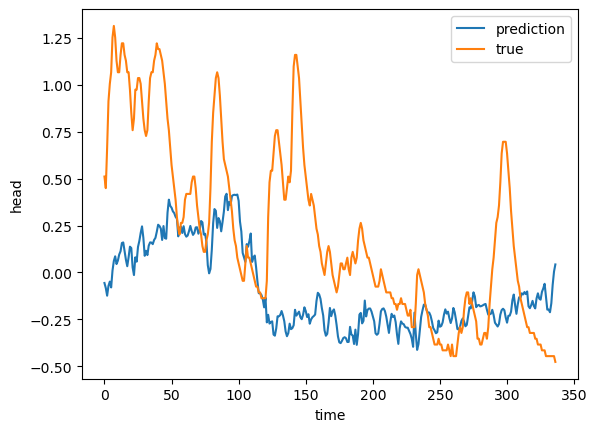

In [322]:
visualize_prediction(y_pred, test_y)

In [321]:
def visualize_prediction(pred, true):

    plt.plot(pred, label = "prediction")
    plt.plot(true, label = "true")
    plt.xlabel('time')
    plt.ylabel('head')
    plt.legend()
    plt.show()


In [245]:
mean_squared_error(y_pred, y_test)

0.03796245624304512